In [1]:
import torch
import numpy as np
from torchvision import datasets, transforms
from pathlib import Path
import spyrit.misc.walsh_hadamard as wh
import sys

from spyrit.misc.statistics import stat_walsh_stl10
# from spyrit.misc.statistics import *
from spyrit.misc.disp import *

from spyrit.learning.model_Had_DCAN import *

In [2]:
img_size = 64 # image size
M = 512
N0 = 2    # Image intensity (in photons)
bs = 5 # Batch size

#- Model and data paths
data_root = Path('../../datasets/')
stats_root = Path('../2022_OE_spyrit2/models_online')

In [3]:
#%% A batch of STL-10 test images
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(7)

transform = transforms.Compose(
    [transforms.functional.to_grayscale,
     transforms.Resize((img_size, img_size)),
     transforms.ToTensor(),
     transforms.Normalize([0.5], [0.5])])

testset = \
    datasets.STL10(root=data_root, split='test',download=False, transform=transform)
testloader =  torch.utils.data.DataLoader(testset, batch_size=bs, shuffle=False)

In [4]:
inputs, _ = next(iter(testloader))
b,c,h,w = inputs.shape

In [5]:
# stat_walsh_stl10()
Cov = np.load(stats_root / Path("Cov_{}x{}.npy".format(img_size, img_size)))
Mean = np.load(stats_root / Path("Average_{}x{}.npy".format(img_size, img_size)))
H =  wh.walsh2_matrix(img_size)
# H =  wh.walsh2_matrix(img_size)/img_size


Ord = Cov2Var(Cov)
Perm = Permutation_Matrix(Ord)
Hperm = Perm@H; #for new
Pmat = Hperm[:M,:];


Cov_had = Cov/img_size**2 # previous
Mean_had = Mean/img_size # previous

Cov_perm = Perm@Cov@Perm.T

In [6]:
x = inputs.view(b*c,w*h)
x_0 = torch.zeros_like(x)

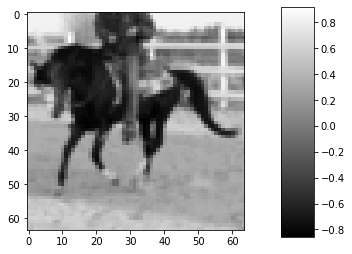

In [7]:
img = x[0,:]
img = img.numpy();
imagesc(np.reshape(img,(h,w)))

# Generalized_Orthogonal_Tikhonov (Validated)
## Instantiation

In [15]:
from spyrit.restructured.Updated_Had_Dcan import * 

# pseudo-inverse-net
Pinv = Pinv_orthogonal()

# mmse-net
FO_split = Split_Forward_operator_ft_had(Pmat, Perm)
A_b = Bruit_Poisson_approx_Gauss(N0, FO_split)
SPP = Split_diag_poisson_preprocess(N0, M, w*h)

P = Generalized_Orthogonal_Tikhonov(sigma_prior = Cov_perm, M = M, N = h*w)
Denoi = ConvNet()
MmmseNet = DC_Net(A_b, SPP, P, Denoi)

In [17]:
FO_split.inverse

<bound method Split_Forward_operator_ft_had.inverse of Split_Forward_operator_ft_had(
  (Hsub): Linear(in_features=4096, out_features=512, bias=False)
  (Hsub_adjoint): Linear(in_features=512, out_features=4096, bias=False)
  (Hpos_neg): Linear(in_features=4096, out_features=1024, bias=False)
  (Perm): Linear(in_features=4096, out_features=4096, bias=False)
)>

## Simulate data

In [9]:
m = A_b(x)
y = SPP(m, FO_split)
var = SPP.sigma(m)

## MMSE reconstruction from DC module only

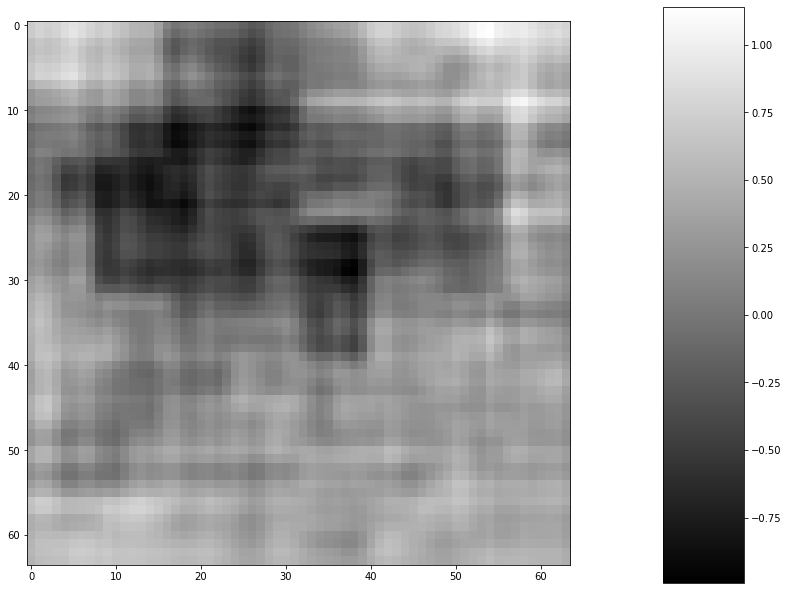

In [10]:
x_est_P = P(y, x_0, var, FO_split)
plt.rcParams['figure.figsize'] = [15, 10]
img = x_est_P[0,:]
img = img.detach().numpy();
imagesc(np.reshape(img,(h,w)))

## MMSE reconstruction from full Network

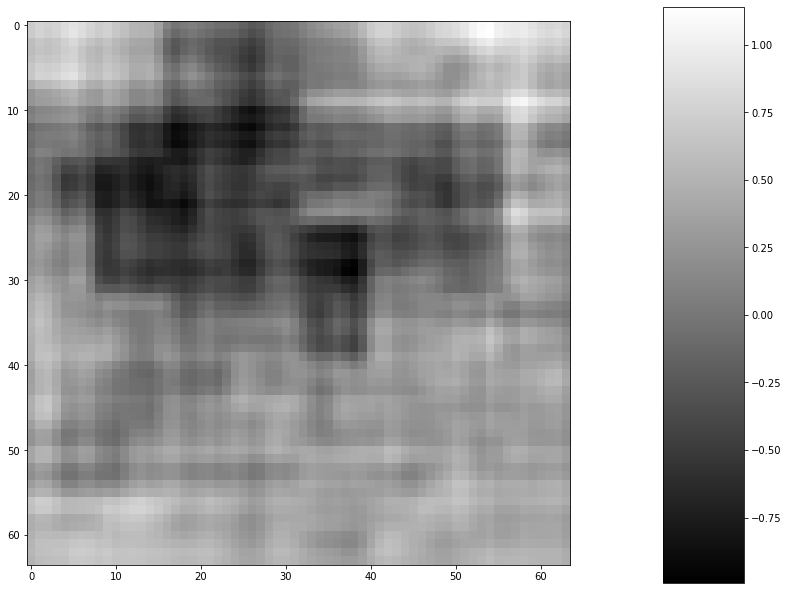

In [11]:
x_est_model = MmmseNet.reconstruct_mmse(m.view(5,1,-1))
plt.rcParams['figure.figsize'] = [15, 10]
img = x_est_model[0,:]
img = img.detach().numpy();
imagesc(np.reshape(img,(h,w)))

## PInv reconstruction from DC module only

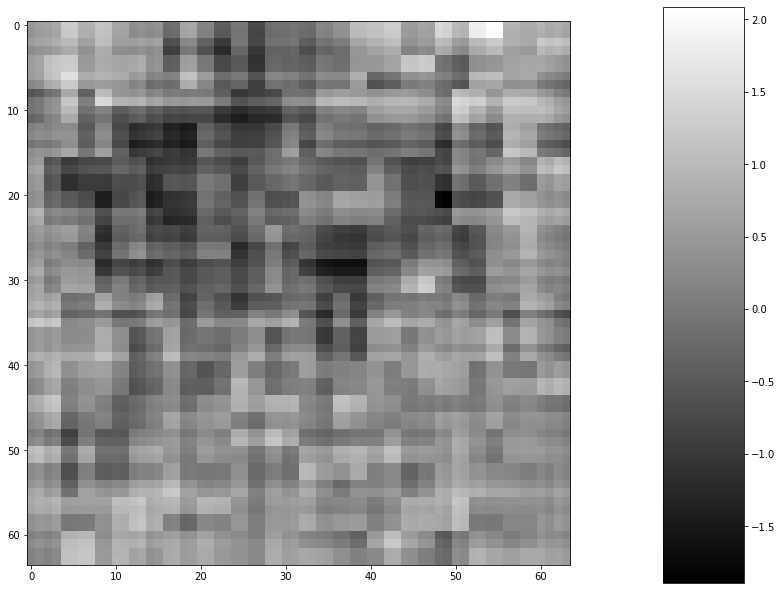

In [12]:
x_est = Pinv(y, FO_split)
plt.rcParams['figure.figsize'] = [15, 10]
img = x_est[0,:]
img = img.detach().numpy();
imagesc(np.reshape(img,(h,w)))

In [21]:
N0_list = [2, 5, 10, 50, 2500];
outlist = [];
out_pinv = [];
prevlist = [];
for N0 in N0_list:
    A_b = Bruit_Poisson_approx_Gauss(N0, FO_split)
    SPP = Split_diag_poisson_preprocess(N0, M, w*h)
    
    model = DenoiCompNet(img_size, M, Mean_had, Cov_had, variant=0, N0=N0, H=H/img_size)
    model.eval();
    
    m = A_b(x);
    m_mem = torch.clone(m)
    y = SPP(m, FO_split);
    var = SPP.sigma(m);

    
    x_Pinv = Pinv(y, FO_split);
    out_pinv.append(torch2numpy(x_Pinv.view(1,bs, 1, h, w)))
    
    x_est = P(y, x_0, var, FO_split);
    outlist.append(torch2numpy(x_est.view(1,bs, 1, h, w)))
    
    recon_free = model.forward_reconstruct_mmse(m_mem, b, c, h, w)

    prevlist.append(torch2numpy(recon_free.view(1,bs, 1, h, w)))
    

Measurement to image domain: statistical completion (no mean)
Varying N0 = 2 +/- 0
Denoised Measurements
Measurement to image domain: statistical completion (no mean)
Varying N0 = 5 +/- 0
Denoised Measurements
Measurement to image domain: statistical completion (no mean)
Varying N0 = 10 +/- 0
Denoised Measurements
Measurement to image domain: statistical completion (no mean)
Varying N0 = 50 +/- 0
Denoised Measurements
Measurement to image domain: statistical completion (no mean)
Varying N0 = 2500 +/- 0
Denoised Measurements


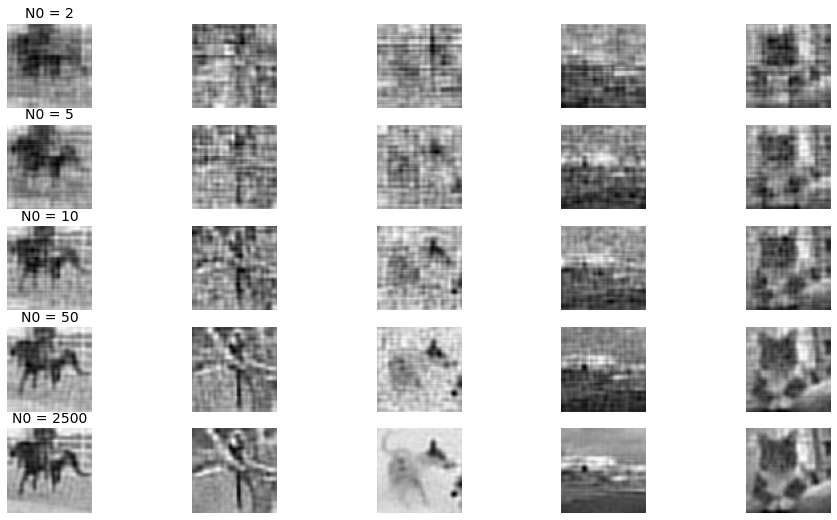

In [22]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [50, 20]

nb_disp_frames = len(N0_list)
outputs_0 = outlist;
title_lists_0 = []
title_lists_0.append(["N0 = 2"]+["" for i in range(bs-1)])
title_lists_0.append(["N0 = 5"]+["" for i in range(bs-1)])
title_lists_0.append(["N0 = 10"]+["" for i in range(bs-1)])
title_lists_0.append(["N0 = 50"]+["" for i in range(bs-1)])
title_lists_0.append(["N0 = 2500"]+["" for i in range(bs-1)])
compare_video_frames(outputs_0, nb_disp_frames, title_lists_0, savefig = '');

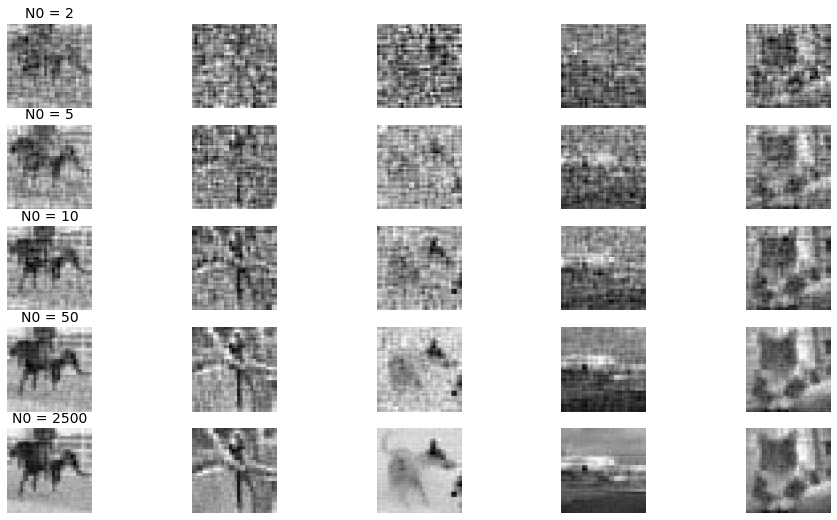

In [23]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [50, 20]

nb_disp_frames = len(N0_list)
outputs_0 = out_pinv;
title_lists_0 = []
title_lists_0.append(["N0 = 2"]+["" for i in range(bs-1)])
title_lists_0.append(["N0 = 5"]+["" for i in range(bs-1)])
title_lists_0.append(["N0 = 10"]+["" for i in range(bs-1)])
title_lists_0.append(["N0 = 50"]+["" for i in range(bs-1)])
title_lists_0.append(["N0 = 2500"]+["" for i in range(bs-1)])
compare_video_frames(outputs_0, nb_disp_frames, title_lists_0,savefig = '');

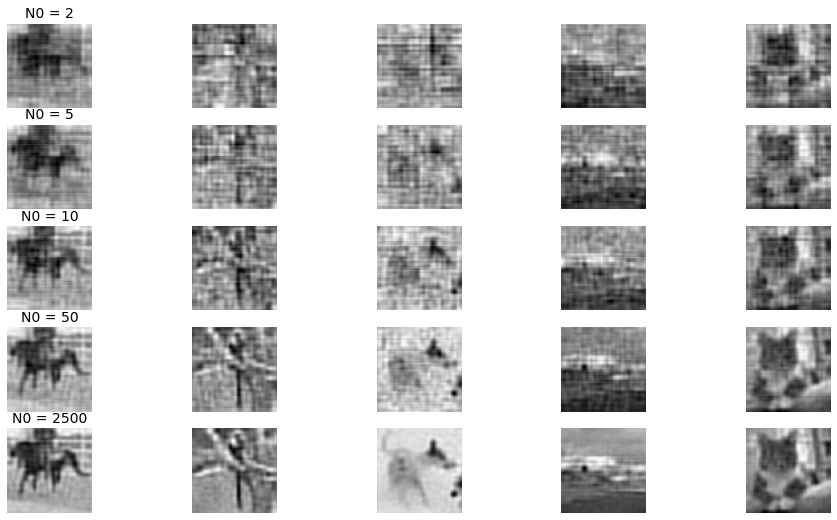

In [24]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [50, 20]

nb_disp_frames = len(N0_list)
outputs_0 = prevlist;
title_lists_0 = []
title_lists_0.append(["N0 = 2"]+["" for i in range(bs-1)])
title_lists_0.append(["N0 = 5"]+["" for i in range(bs-1)])
title_lists_0.append(["N0 = 10"]+["" for i in range(bs-1)])
title_lists_0.append(["N0 = 50"]+["" for i in range(bs-1)])
title_lists_0.append(["N0 = 2500"]+["" for i in range(bs-1)])
compare_video_frames(outputs_0, nb_disp_frames, title_lists_0,savefig = '');

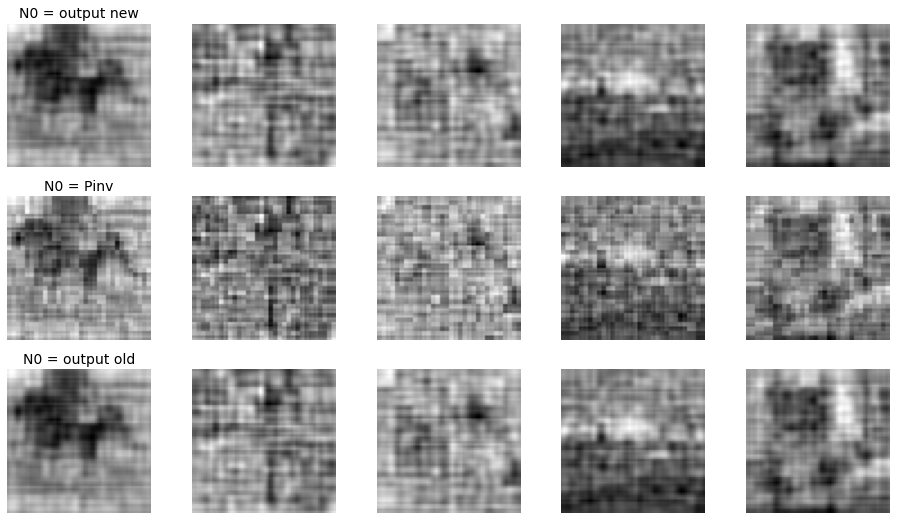

In [25]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [50, 20]

nb_disp_frames = len(N0_list)
outputs_0 = [outlist[1], out_pinv[1], prevlist[1]];
title_lists_0 = []
title_lists_0.append(["N0 = output new"]+["" for i in range(bs-1)]) 
title_lists_0.append(["N0 = Pinv"]+["" for i in range(bs-1)])
title_lists_0.append(["N0 = output old"]+["" for i in range(bs-1)])
compare_video_frames(outputs_0, nb_disp_frames, title_lists_0,savefig = '');

## Difference between reconstrcution using spyrit v1.2 and spyrit v2

In [47]:
print(np.linalg.norm(outlist[0]-prevlist[0]))

1.4213788e-05
